## Temp

In [2]:
import xarray as xr
data_temp = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Temp\*.nc", parallel=True)
data_tmax = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_tmax\*.nc", parallel=True)
data_tmin = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_tmin\*.nc", parallel=True)
data_rain = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Rain\*.nc", parallel=True)
data_hurs = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Humidity\*.nc", parallel=True)
data_sun = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Sun\*.nc", parallel=True)
data_frost = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Frost\*.nc", parallel=True)
data_psl = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_psl\*.nc", parallel=True)
data_wind = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Wind\*.nc", parallel=True)

In [3]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

projection_x_coordinate = np.array(data_temp['projection_x_coordinate'])
projection_y_coordinate = np.array(data_temp['projection_y_coordinate'])

scaler = MinMaxScaler()

# Normalize spatial coordinates
pyc = scaler.fit_transform(projection_y_coordinate.reshape(-1, 1))
pxc = scaler.fit_transform(projection_x_coordinate.reshape(-1, 1))


In [4]:
rain = np.array(data_rain['rainfall'])
hurs = np.array(data_hurs['hurs'])
temp = np.array(data_temp['tas'])
temp_max = np.array(data_tmax['tasmax'])
temp_min = np.array(data_tmin['tasmin'])
sun = np.array(data_sun['sun'])
frost = np.array(data_frost['groundfrost'])
psl = np.array(data_psl['psl'])
wind = np.array(data_wind['sfcWind'])

In [5]:
min_length = len(wind)
rain = rain[:min_length]
hurs = hurs[:min_length]
temp = temp[:min_length]
temp_max = temp_max[:min_length]
temp_min = temp_min[:min_length]
sun = sun[:min_length]
frost = frost[:min_length]
wind = wind[:min_length]
psl = psl[:min_length]

In [6]:
import numpy as np
import pandas as pd

# Create meshgrid for spatial coordinates
pyc_mesh, pxc_mesh = np.meshgrid(pyc.flatten(), pxc.flatten())

# Flatten the meshgrid arrays
pyc_flat = pyc_mesh.flatten()
pxc_flat = pxc_mesh.flatten()

# Repeat each spatial coordinate combination for the number of time values
num_time_values = len(rain)
pyc_flat = np.repeat(pyc_flat, num_time_values)
pxc_flat = np.repeat(pxc_flat, num_time_values)

# Flatten time arrays
rain_flat = rain.flatten()
hurs_flat = hurs.flatten()
temp_flat = temp.flatten()
temp_max_flat = temp_max.flatten()
temp_min_flat = temp_min.flatten()
sun_flat = sun.flatten()
frost_flat = frost.flatten()
psl_flat = psl.flatten()
wind_flat = wind.flatten()

# Create DataFrame
df = pd.DataFrame({
    'projection_y_coordinate': pyc_flat,
    'projection_x_coordinate': pxc_flat,
    'Rain': rain_flat,
    'Hurs': hurs_flat,
    'Temp': temp_flat,
    'Temp_Min': temp_min_flat,
    'Temp_Max': temp_max_flat,
    'Sun': sun_flat,
    'Frost': frost_flat,
    'Psl': psl_flat,
    'Wind': wind_flat
})

In [7]:
# List of columns to check for NaN values
columns_to_check = ['Rain', 'Hurs', 'Temp', 'Sun', 'Frost', 'Psl', 'Wind', 'Temp_Min', 'Temp_Max']

# Create a boolean mask indicating rows with NaN values in the specified columns
nan_mask = df[columns_to_check].isnull().any(axis=1)

# Filter the DataFrame to keep rows without NaN values in the specified columns
df_filtered = df[~nan_mask]

In [8]:
# Define the range of years
start_year = 1969
end_year = 2022

# Define the years you want to assign to each row
years = np.arange(start_year, end_year + 1)

# Repeat each year for each combination of spatial coordinate and time value once
num_combinations = len(df_filtered) 
years_repeated = np.tile(years, num_combinations)

# Add the year column to your DataFrame using .loc
df_filtered.loc[:, 'Year'] = years_repeated[:len(df_filtered)]


C:\Users\iarla\AppData\Local\Temp\ipykernel_5816\2115229586.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.loc[:, 'Year'] = years_repeated[:len(df_filtered)]


In [9]:
# Define the years of interest
years_of_interest = range(2013, 2023)

# Filter rows based on the years of interest
rows_of_interest = df_filtered[df_filtered['Year'].isin(years_of_interest)]

# Check if there are any rows in the filtered DataFrame
if not rows_of_interest.empty:
    print("Data available for the specified years.")
else:
    print("No data available for the specified years.")

Data available for the specified years.


In [17]:
# Define the years of interest
years_of_interest = range(2013, 2023)

# Find the indices of rows corresponding to the years of interest
indices_of_interest = df_filtered[df_filtered['Year'].isin(years_of_interest)].index

# Create a new DataFrame with the rows corresponding to the years of interest
new_df_filtered = df_filtered.loc[indices_of_interest].copy()

# Remove the filtered rows from the original DataFrame by creating a copy
df_filtered = df_filtered.drop(indices_of_interest)

In [18]:
# Target variable (future temperatures over the entire grid)
y = df_filtered['Temp'].values

# Features
X = df_filtered.drop(['Temp', 'Rain', 'Hurs', 'Sun', 'Frost', 'Psl', 'Wind', 'Temp_Min', 'Temp_Max', 'projection_y_coordinate', 'projection_x_coordinate'], axis=1).values

Mean Squared Error: 20.412862470109637
R-squared Value: -9.677697026222454e-05


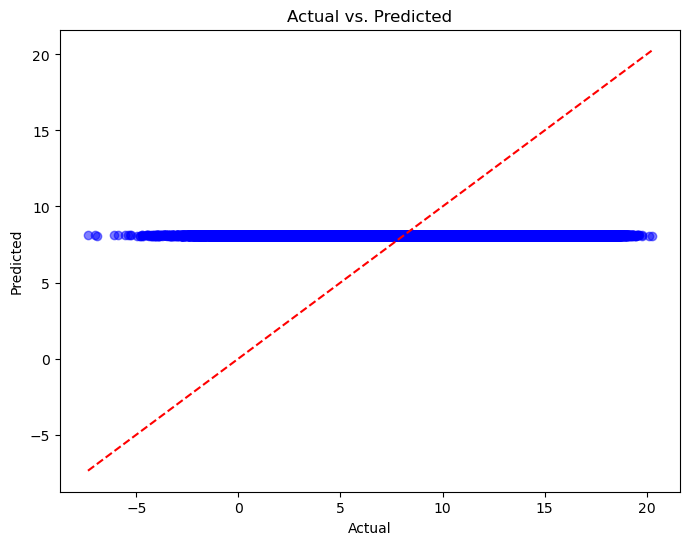

In [19]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and Train the Gradient Boosting Regression Model
gb_regressor = GradientBoostingRegressor(learning_rate=0.1, n_estimators=150, max_depth=3)
gb_regressor.fit(X_train, y_train)


y_pred = gb_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate R-squared value
r_squared = r2_score(y_test, y_pred)
print("R-squared Value:", r_squared)

# Create a scatter plot of actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.show()

In [21]:
# Separate the temperature column before prediction
X_temp = new_df_filtered['Temp'].values.reshape(-1, 1)
X_new = new_df_filtered.drop(['Temp', 'Rain', 'Hurs', 'Sun', 'Frost', 'Psl', 'Wind', 'Temp_Min', 'Temp_Max', 'projection_y_coordinate', 'projection_x_coordinate'], axis=1).values

# Assuming rf_model is your trained Random Forest model
future_predictions = gb_regressor.predict(X_new)

print(future_predictions)
print(future_predictions.shape)

[8.12542499 8.12542499 8.12542499 ... 8.12542499 8.12542499 8.12542499]
(204610,)


In [22]:
# Assuming X_temp and future_predictions are NumPy arrays
comparison_df = pd.DataFrame({
    'Actual Temp': X_temp.flatten(),  # Flatten to make sure it's a 1D array
    'Predicted Temp': future_predictions
})

# Display the DataFrame
print(comparison_df)

        Actual Temp  Predicted Temp
0          7.066459        8.125425
1          7.171069        8.125425
2          6.388286        8.125425
3          6.395669        8.125425
4          6.753537        8.125425
...             ...             ...
204605     2.843987        8.125425
204606     2.971155        8.125425
204607     2.712619        8.125425
204608     3.238767        8.125425
204609     2.817050        8.125425

[204610 rows x 2 columns]


In [23]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

r2 = r2_score(comparison_df['Actual Temp'], comparison_df['Predicted Temp'])
print(f"R-squared: {r2}")


mae = mean_absolute_error(comparison_df['Actual Temp'], comparison_df['Predicted Temp'])
print(f"Mean Absolute Error: {mae}")


mse = mean_squared_error(comparison_df['Actual Temp'], comparison_df['Predicted Temp'])
print(f"Mean Squared Error: {mse}")

R-squared: -5.14742804900159e-05
Mean Absolute Error: 3.9052116158686383
Mean Squared Error: 20.450123742610376


In [ ]:
import seaborn as sns
# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Actual Temp', y='Predicted Temp', data=comparison_df, alpha=0.7)
plt.title('Actual vs. Predicted Temp')
plt.xlabel('Actual Temp')
plt.ylabel('Predicted Temp')

# Regression line
sns.regplot(x='Actual Temp', y='Predicted Temp', data=comparison_df, scatter=False, color='red')

# Residual plot
plt.figure(figsize=(10, 6))
sns.residplot(x='Actual Temp', y='Predicted Temp', data=comparison_df, lowess=True, color='blue')
plt.title('Residual Plot')
plt.xlabel('Actual Temp')
plt.ylabel('Residuals')

## Averaging over grid

In [40]:
import numpy as np
import pandas as pd
from skimage.measure import block_reduce

temp_reduced = block_reduce(temp, block_size=(12, 1, 1), func=np.mean, cval=np.mean(temp))
temp_spatial = np.nanmean(temp_reduced, axis=(1,2))
time = np.arange(1884,2023)

# Create DataFrame
df = pd.DataFrame({
    'Temp': temp_spatial,
    'Year': time
})

In [41]:
# List of columns to check for NaN values
columns_to_check = ['Temp']

# Create a boolean mask indicating rows with NaN values in the specified columns
nan_mask = df[columns_to_check].isnull().any(axis=1)

# Filter the DataFrame to keep rows without NaN values in the specified columns
df_filtered = df[~nan_mask]

In [34]:
time.shape

(54,)

In [42]:
# Define the years of interest
years_of_interest = range(2013, 2023)

# Filter rows based on the years of interest
rows_of_interest = df_filtered[df_filtered['Year'].isin(years_of_interest)]

# Check if there are any rows in the filtered DataFrame
if not rows_of_interest.empty:
    print("Data available for the specified years.")
else:
    print("No data available for the specified years.")

Data available for the specified years.


In [43]:
# Define the years of interest
years_of_interest = range(2013, 2023)

# Find the indices of rows corresponding to the years of interest
indices_of_interest = df_filtered[df_filtered['Year'].isin(years_of_interest)].index

# Create a new DataFrame with the rows corresponding to the years of interest
new_df_filtered = df_filtered.loc[indices_of_interest].copy()

# Remove the filtered rows from the original DataFrame by creating a copy
df_filtered = df_filtered.drop(indices_of_interest)

In [44]:
# Target variable (future temperatures over the entire grid)
y = df_filtered['Temp'].values

# Features
X = df_filtered.drop(['Temp'], axis=1).values

Mean Squared Error: 0.21731402760417057
R-squared Value: 0.28767897950945376


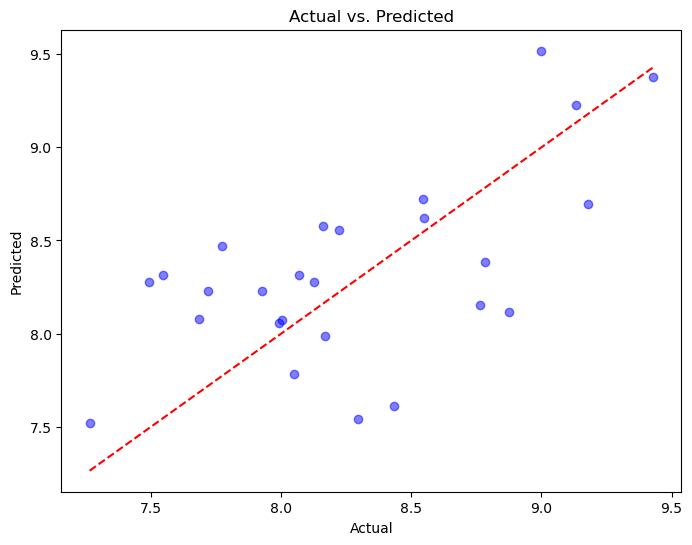

In [45]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and Train the Gradient Boosting Regression Model
gb_regressor = GradientBoostingRegressor(learning_rate=0.1, n_estimators=150, max_depth=3)
gb_regressor.fit(X_train, y_train)


y_pred = gb_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate R-squared value
r_squared = r2_score(y_test, y_pred)
print("R-squared Value:", r_squared)

# Create a scatter plot of actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.show()

In [46]:
# Separate the temperature column before prediction
X_temp = new_df_filtered['Temp'].values.reshape(-1, 1)
X_new = new_df_filtered.drop(['Temp'], axis=1).values

# Assuming rf_model is your trained Random Forest model
future_predictions = gb_regressor.predict(X_new)

print(future_predictions)
print(future_predictions.shape)

[8.74474718 8.74474718 8.74474718 8.74474718 8.74474718 8.74474718
 8.74474718 8.74474718 8.74474718 8.74474718]
(10,)


In [47]:
# Assuming X_temp and future_predictions are NumPy arrays
comparison_df = pd.DataFrame({
    'Actual Temp': X_temp.flatten(),  # Flatten to make sure it's a 1D array
    'Predicted Temp': future_predictions
})

# Display the DataFrame
print(comparison_df)

   Actual Temp  Predicted Temp
0     8.694078        8.744747
1     9.841629        8.744747
2     9.134825        8.744747
3     9.253900        8.744747
4     9.492679        8.744747
5     9.389196        8.744747
6     9.357949        8.744747
7     9.593366        8.744747
8     9.247745        8.744747
9     9.986207        8.744747


In [48]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

r2 = r2_score(comparison_df['Actual Temp'], comparison_df['Predicted Temp'])
print(f"R-squared: {r2}")


mae = mean_absolute_error(comparison_df['Actual Temp'], comparison_df['Predicted Temp'])
print(f"Mean Absolute Error: {mae}")


mse = mean_squared_error(comparison_df['Actual Temp'], comparison_df['Predicted Temp'])
print(f"Mean Squared Error: {mse}")

R-squared: -3.569658577399979
Mean Absolute Error: 0.664544066793226
Mean Squared Error: 0.5482230480709979


Text(0, 0.5, 'Residuals')

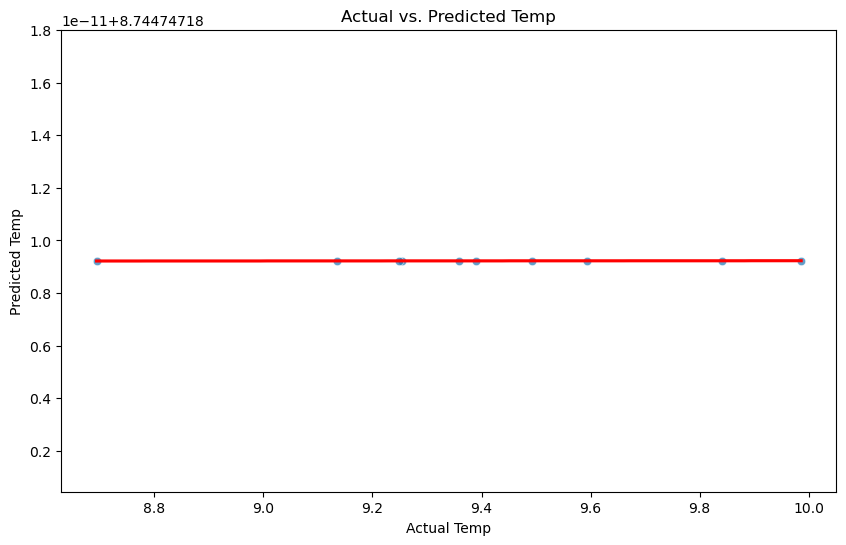

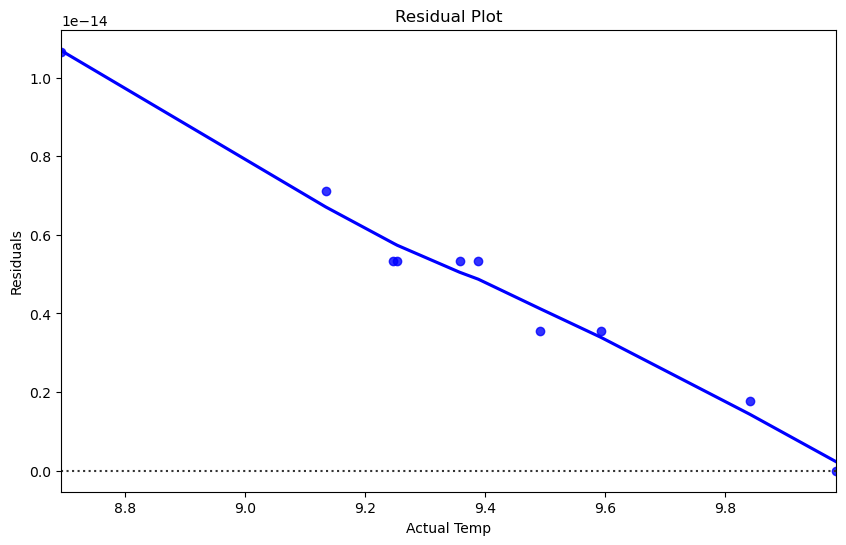

In [49]:
import seaborn as sns
# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Actual Temp', y='Predicted Temp', data=comparison_df, alpha=0.7)
plt.title('Actual vs. Predicted Temp')
plt.xlabel('Actual Temp')
plt.ylabel('Predicted Temp')

# Regression line
sns.regplot(x='Actual Temp', y='Predicted Temp', data=comparison_df, scatter=False, color='red')

# Residual plot
plt.figure(figsize=(10, 6))
sns.residplot(x='Actual Temp', y='Predicted Temp', data=comparison_df, lowess=True, color='blue')
plt.title('Residual Plot')
plt.xlabel('Actual Temp')
plt.ylabel('Residuals')

## Try with different variable. Humidity

In [51]:
import numpy as np
import pandas as pd
from skimage.measure import block_reduce

hurs_reduced = block_reduce(hurs, block_size=(12, 1, 1), func=np.mean, cval=np.mean(hurs))
hurs_spatial = np.nanmean(hurs_reduced, axis=(1,2))
time = np.arange(1961,2023)

# Create DataFrame
df = pd.DataFrame({
    'Hurs': hurs_spatial,
    'Year': time
})

In [52]:
# List of columns to check for NaN values
columns_to_check = ['Hurs']

# Create a boolean mask indicating rows with NaN values in the specified columns
nan_mask = df[columns_to_check].isnull().any(axis=1)

# Filter the DataFrame to keep rows without NaN values in the specified columns
df_filtered = df[~nan_mask]

In [53]:
# Define the years of interest
years_of_interest = range(2013, 2023)

# Filter rows based on the years of interest
rows_of_interest = df_filtered[df_filtered['Year'].isin(years_of_interest)]

# Check if there are any rows in the filtered DataFrame
if not rows_of_interest.empty:
    print("Data available for the specified years.")
else:
    print("No data available for the specified years.")

Data available for the specified years.


In [54]:
# Define the years of interest
years_of_interest = range(2013, 2023)

# Find the indices of rows corresponding to the years of interest
indices_of_interest = df_filtered[df_filtered['Year'].isin(years_of_interest)].index

# Create a new DataFrame with the rows corresponding to the years of interest
new_df_filtered = df_filtered.loc[indices_of_interest].copy()

# Remove the filtered rows from the original DataFrame by creating a copy
df_filtered = df_filtered.drop(indices_of_interest)

In [55]:
# Target variable (future temperatures over the entire grid)
y = df_filtered['Hurs'].values

# Features
X = df_filtered.drop(['Hurs'], axis=1).values

Mean Squared Error: 0.524661095653712
R-squared Value: -0.3073260536441096


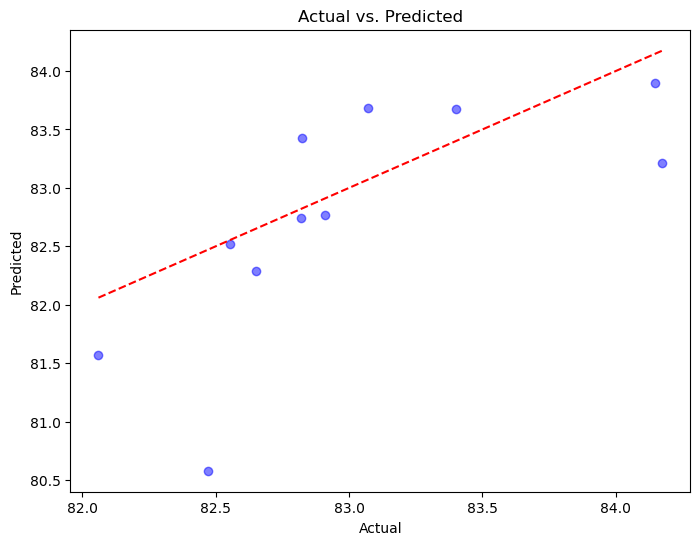

In [56]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and Train the Gradient Boosting Regression Model
gb_regressor = GradientBoostingRegressor(learning_rate=0.1, n_estimators=150, max_depth=3)
gb_regressor.fit(X_train, y_train)


y_pred = gb_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate R-squared value
r_squared = r2_score(y_test, y_pred)
print("R-squared Value:", r_squared)

# Create a scatter plot of actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.show()

In [57]:
# Separate the temperature column before prediction
X_temp = new_df_filtered['Hurs'].values.reshape(-1, 1)
X_new = new_df_filtered.drop(['Hurs'], axis=1).values

# Assuming rf_model is your trained Random Forest model
future_predictions = gb_regressor.predict(X_new)

print(future_predictions)
print(future_predictions.shape)

[83.71398655 83.71398655 83.71398655 83.71398655 83.71398655 83.71398655
 83.71398655 83.71398655 83.71398655 83.71398655]
(10,)


In [58]:
# Assuming X_temp and future_predictions are NumPy arrays
comparison_df = pd.DataFrame({
    'Actual Hurs': X_temp.flatten(),  # Flatten to make sure it's a 1D array
    'Predicted Hurs': future_predictions
})

# Display the DataFrame
print(comparison_df)

   Actual Hurs  Predicted Hurs
0    81.377878       83.713987
1    83.344048       83.713987
2    81.977419       83.713987
3    83.378172       83.713987
4    83.392087       83.713987
5    81.901780       83.713987
6    82.737965       83.713987
7    81.827022       83.713987
8    82.725019       83.713987
9    80.935507       83.713987


In [59]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

r2 = r2_score(comparison_df['Actual Hurs'], comparison_df['Predicted Hurs'])
print(f"R-squared: {r2}")


mae = mean_absolute_error(comparison_df['Actual Hurs'], comparison_df['Predicted Hurs'])
print(f"Mean Absolute Error: {mae}")


mse = mean_squared_error(comparison_df['Actual Hurs'], comparison_df['Predicted Hurs'])
print(f"Mean Squared Error: {mse}")

R-squared: -2.6275034792003855
Mean Absolute Error: 1.3542966865488624
Mean Squared Error: 2.5321659801082452


Text(0, 0.5, 'Residuals')

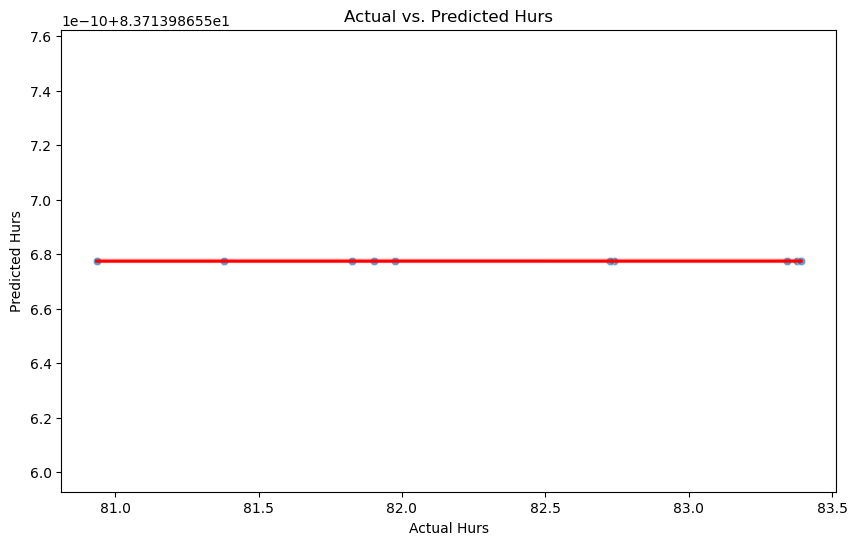

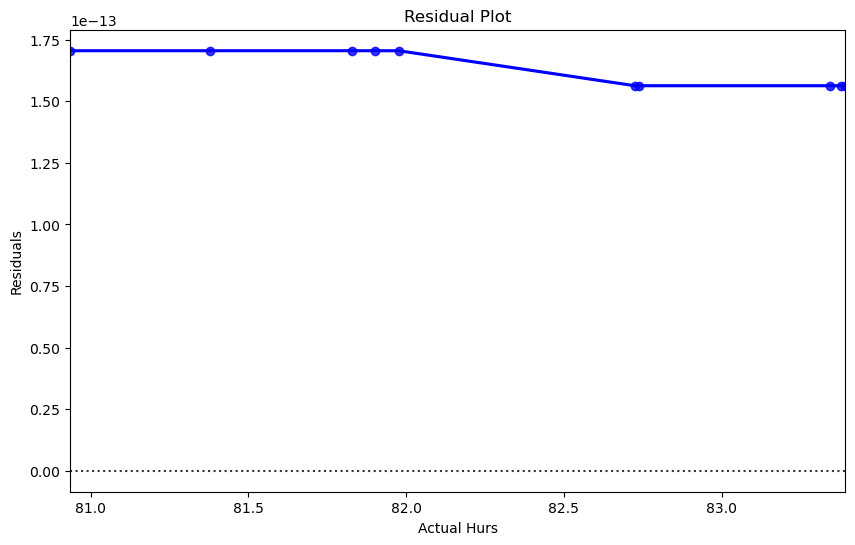

In [60]:
import seaborn as sns
# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Actual Hurs', y='Predicted Hurs', data=comparison_df, alpha=0.7)
plt.title('Actual vs. Predicted Hurs')
plt.xlabel('Actual Hurs')
plt.ylabel('Predicted Hurs')

# Regression line
sns.regplot(x='Actual Hurs', y='Predicted Hurs', data=comparison_df, scatter=False, color='red')

# Residual plot
plt.figure(figsize=(10, 6))
sns.residplot(x='Actual Hurs', y='Predicted Hurs', data=comparison_df, lowess=True, color='blue')
plt.title('Residual Plot')
plt.xlabel('Actual Hurs')
plt.ylabel('Residuals')

# Different algorithm KNN

## Entire grid average

In [3]:
import numpy as np
import xarray as xr
import pandas as pd
from skimage.measure import block_reduce

data_temp = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Temp\*.nc", parallel=True)
temp = np.array(data_temp['tas'])
temp_reduced = block_reduce(temp, block_size=(12, 1, 1), func=np.mean, cval=np.mean(temp))
temp_spatial = np.nanmean(temp_reduced, axis=(1,2))
time = np.arange(1884,2023)

# Create DataFrame
df = pd.DataFrame({
    'Temp': temp_spatial,
    'Year': time
})

In [4]:
# List of columns to check for NaN values
columns_to_check = ['Temp']

# Create a boolean mask indicating rows with NaN values in the specified columns
nan_mask = df[columns_to_check].isnull().any(axis=1)

# Filter the DataFrame to keep rows without NaN values in the specified columns
df_filtered = df[~nan_mask]

In [5]:
# Define the years of interest
years_of_interest = range(2013, 2023)

# Filter rows based on the years of interest
rows_of_interest = df_filtered[df_filtered['Year'].isin(years_of_interest)]

# Check if there are any rows in the filtered DataFrame
if not rows_of_interest.empty:
    print("Data available for the specified years.")
else:
    print("No data available for the specified years.")

Data available for the specified years.


In [6]:
# Define the years of interest
years_of_interest = range(2013, 2023)

# Find the indices of rows corresponding to the years of interest
indices_of_interest = df_filtered[df_filtered['Year'].isin(years_of_interest)].index

# Create a new DataFrame with the rows corresponding to the years of interest
new_df_filtered = df_filtered.loc[indices_of_interest].copy()

# Remove the filtered rows from the original DataFrame by creating a copy
df_filtered = df_filtered.drop(indices_of_interest)

In [7]:
# Target variable (future temperatures over the entire grid)
y = df_filtered['Temp'].values

# Features
X = df_filtered.drop(['Temp'], axis=1).values

Mean Squared Error: 0.1544733819107857
R-squared Value: 0.49366067964217775


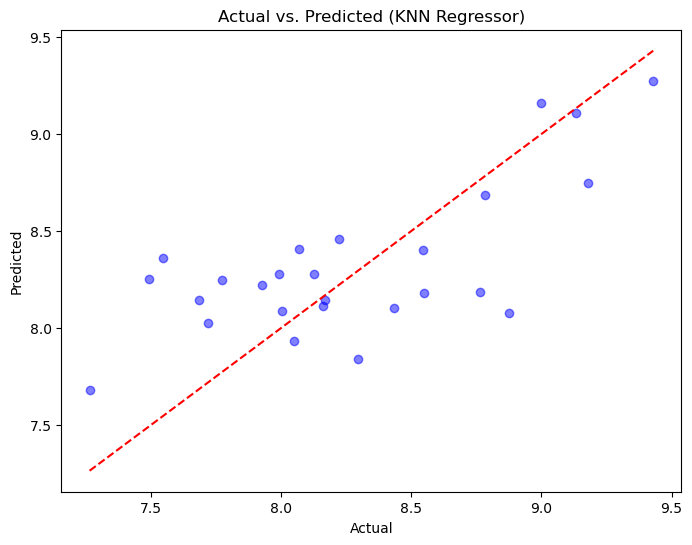

In [8]:
from sklearn.neighbors import KNeighborsRegressor  
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and Train the KNN Regression Model
knn_regressor = KNeighborsRegressor(n_neighbors=5, weights='distance')  
knn_regressor.fit(X_train, y_train)


y_pred = knn_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate R-squared value
r_squared = r2_score(y_test, y_pred)
print("R-squared Value:", r_squared)

# Create a scatter plot of actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted (KNN Regressor)') 
plt.show()

In [9]:
# Separate the temperature column before prediction
X_temp = new_df_filtered['Temp'].values.reshape(-1, 1)
X_new = new_df_filtered.drop(['Temp'], axis=1).values

# Assuming rf_model is your trained Random Forest model
future_predictions = knn_regressor.predict(X_new)

print(future_predictions)
print(future_predictions.shape)

[8.8868759  8.90787156 8.91725061 8.92332304 8.92781978 8.93136083
 8.93424851 8.93665886 8.9387057  8.94046758]
(10,)


In [10]:
# Assuming X_temp and future_predictions are NumPy arrays
comparison_df = pd.DataFrame({
    'Actual Temp': X_temp.flatten(),  # Flatten to make sure it's a 1D array
    'Predicted Temp': future_predictions
})

# Display the DataFrame
print(comparison_df)

   Actual Temp  Predicted Temp
0     8.694078        8.886876
1     9.841629        8.907872
2     9.134825        8.917251
3     9.253900        8.923323
4     9.492679        8.927820
5     9.389196        8.931361
6     9.357949        8.934249
7     9.593366        8.936659
8     9.247745        8.938706
9     9.986207        8.940468


In [11]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

r2 = r2_score(comparison_df['Actual Temp'], comparison_df['Predicted Temp'])
print(f"R-squared: {r2}")


mae = mean_absolute_error(comparison_df['Actual Temp'], comparison_df['Predicted Temp'])
print(f"Mean Absolute Error: {mae}")


mse = mean_squared_error(comparison_df['Actual Temp'], comparison_df['Predicted Temp'])
print(f"Mean Squared Error: {mse}")

R-squared: -1.8292309696005304
Mean Absolute Error: 0.5132587544069874
Mean Squared Error: 0.3394235257579738


Text(0, 0.5, 'Residuals')

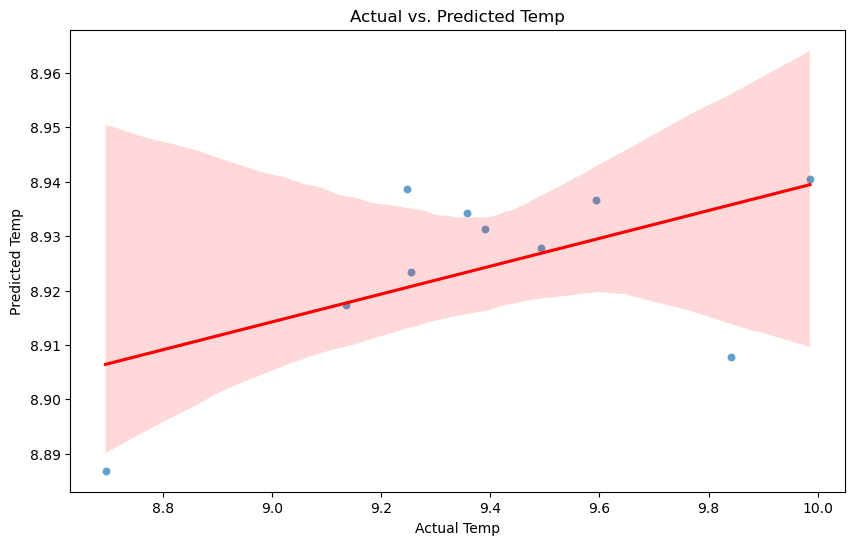

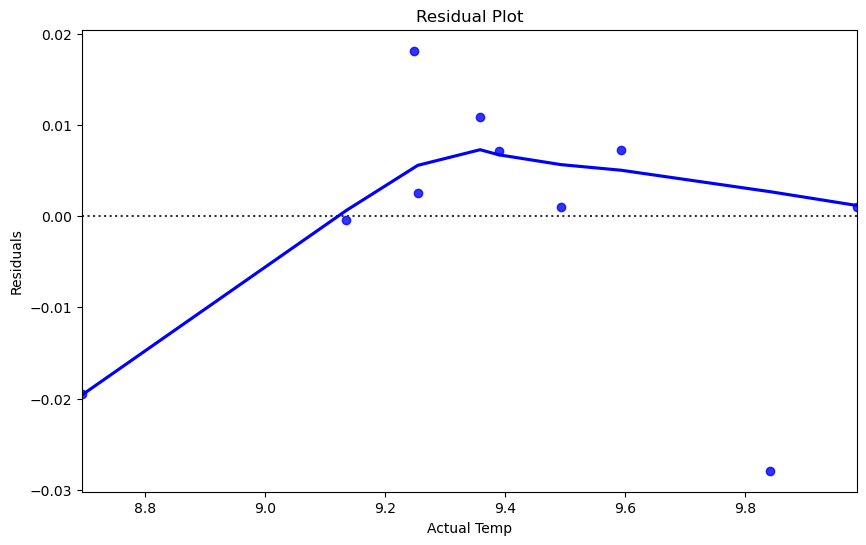

In [12]:
import seaborn as sns
# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Actual Temp', y='Predicted Temp', data=comparison_df, alpha=0.7)
plt.title('Actual vs. Predicted Temp')
plt.xlabel('Actual Temp')
plt.ylabel('Predicted Temp')

# Regression line
sns.regplot(x='Actual Temp', y='Predicted Temp', data=comparison_df, scatter=False, color='red')

# Residual plot
plt.figure(figsize=(10, 6))
sns.residplot(x='Actual Temp', y='Predicted Temp', data=comparison_df, lowess=True, color='blue')
plt.title('Residual Plot')
plt.xlabel('Actual Temp')
plt.ylabel('Residuals')

## With cells

In [22]:
temp = np.array(data_temp['tas'])
temp_reduced = block_reduce(temp, block_size=(12, 1, 1), func=np.mean, cval=np.mean(temp))

# Create DataFrame
df = pd.DataFrame({
    'Temp': temp_reduced.flatten()
})

In [23]:
# List of columns to check for NaN values
columns_to_check = ['Temp']

# Create a boolean mask indicating rows with NaN values in the specified columns
nan_mask = df[columns_to_check].isnull().any(axis=1)

# Filter the DataFrame to keep rows without NaN values in the specified columns
df_filtered = df[~nan_mask]

In [24]:
# Define the range of years
start_year = 1884
end_year = 2022

# Define the years you want to assign to each row
years = np.arange(start_year, end_year + 1)

# Repeat each year for each combination of spatial coordinate and time value once
num_combinations = len(df_filtered) 
years_repeated = np.tile(years, num_combinations)

# Add the year column to your DataFrame using .loc
df_filtered.loc[:, 'Year'] = years_repeated[:len(df_filtered)]

C:\Users\iarla\AppData\Local\Temp\ipykernel_15004\1720730685.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.loc[:, 'Year'] = years_repeated[:len(df_filtered)]


In [25]:
# Define the years of interest
years_of_interest = range(2013, 2023)

# Filter rows based on the years of interest
rows_of_interest = df_filtered[df_filtered['Year'].isin(years_of_interest)]

# Check if there are any rows in the filtered DataFrame
if not rows_of_interest.empty:
    print("Data available for the specified years.")
else:
    print("No data available for the specified years.")

Data available for the specified years.


In [26]:
# Define the years of interest
years_of_interest = range(2013, 2023)

# Find the indices of rows corresponding to the years of interest
indices_of_interest = df_filtered[df_filtered['Year'].isin(years_of_interest)].index

# Create a new DataFrame with the rows corresponding to the years of interest
new_df_filtered = df_filtered.loc[indices_of_interest].copy()

# Remove the filtered rows from the original DataFrame by creating a copy
df_filtered = df_filtered.drop(indices_of_interest)

In [27]:
# Target variable (future temperatures over the entire grid)
y = df_filtered['Temp'].values

# Features
X = df_filtered.drop(['Temp'], axis=1).values

Mean Squared Error: 2.4768671917500718
R-squared Value: -0.20382625643075403


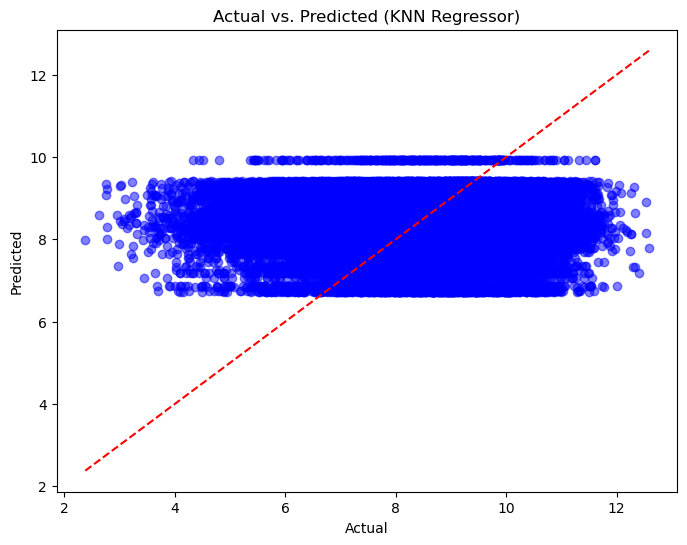

In [28]:
from sklearn.neighbors import KNeighborsRegressor  
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and Train the KNN Regression Model
knn_regressor = KNeighborsRegressor(n_neighbors=5, weights='distance')  
knn_regressor.fit(X_train, y_train)


y_pred = knn_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate R-squared value
r_squared = r2_score(y_test, y_pred)
print("R-squared Value:", r_squared)

# Create a scatter plot of actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted (KNN Regressor)')  
plt.show()

In [29]:
# Separate the temperature column before prediction
X_temp = new_df_filtered['Temp'].values.reshape(-1, 1)
X_new = new_df_filtered.drop(['Temp'], axis=1).values

# Assuming rf_model is your trained Random Forest model
future_predictions = knn_regressor.predict(X_new)

print(future_predictions)
print(future_predictions.shape)

[8.04994757 8.04994757 8.04994757 ... 8.04994757 8.04994757 8.04994757]
(17060,)


In [30]:
# Assuming X_temp and future_predictions are NumPy arrays
comparison_df = pd.DataFrame({
    'Actual Temp': X_temp.flatten(),  # Flatten to make sure it's a 1D array
    'Predicted Temp': future_predictions
})

# Display the DataFrame
print(comparison_df)

       Actual Temp  Predicted Temp
0         9.941907        8.049948
1         9.762531        8.049948
2         9.919578        8.049948
3         9.741699        8.049948
4         9.598860        8.049948
...            ...             ...
17055     7.526921        8.049948
17056     7.400856        8.049948
17057     7.312806        8.049948
17058     7.476390        8.049948
17059     7.983252        8.049948

[17060 rows x 2 columns]


In [31]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

r2 = r2_score(comparison_df['Actual Temp'], comparison_df['Predicted Temp'])
print(f"R-squared: {r2}")


mae = mean_absolute_error(comparison_df['Actual Temp'], comparison_df['Predicted Temp'])
print(f"Mean Absolute Error: {mae}")


mse = mean_squared_error(comparison_df['Actual Temp'], comparison_df['Predicted Temp'])
print(f"Mean Squared Error: {mse}")

R-squared: -0.07242843722041892
Mean Absolute Error: 1.2191899475616585
Mean Squared Error: 2.2001064895508273


Text(0, 0.5, 'Residuals')

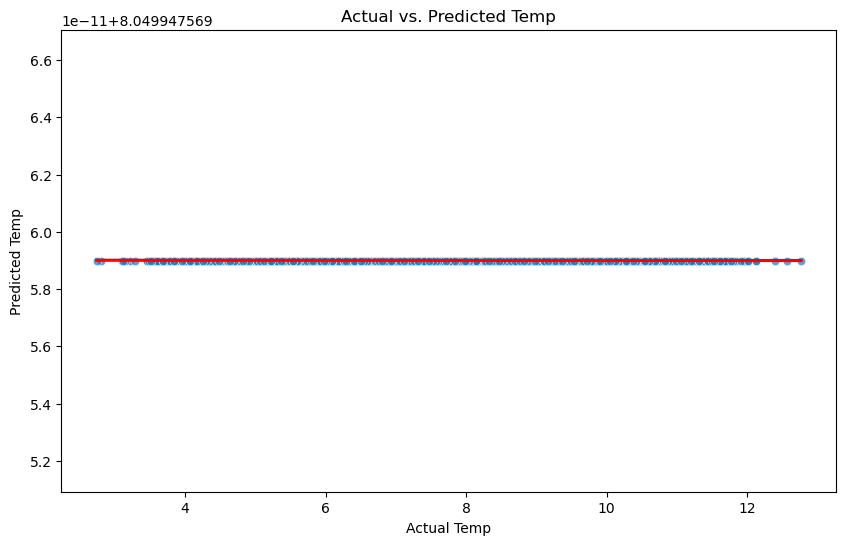

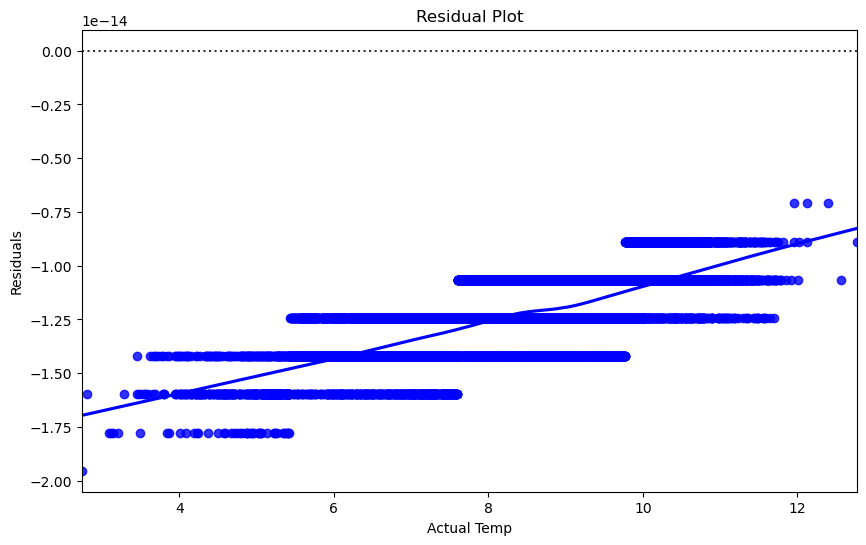

In [32]:
import seaborn as sns
# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Actual Temp', y='Predicted Temp', data=comparison_df, alpha=0.7)
plt.title('Actual vs. Predicted Temp')
plt.xlabel('Actual Temp')
plt.ylabel('Predicted Temp')

# Regression line
sns.regplot(x='Actual Temp', y='Predicted Temp', data=comparison_df, scatter=False, color='red')

# Residual plot
plt.figure(figsize=(10, 6))
sns.residplot(x='Actual Temp', y='Predicted Temp', data=comparison_df, lowess=True, color='blue')
plt.title('Residual Plot')
plt.xlabel('Actual Temp')
plt.ylabel('Residuals')

## Different Variables: Humidity

In [33]:
import numpy as np
import pandas as pd
from skimage.measure import block_reduce

data_hurs = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Humidity\*.nc", parallel=True)
hurs = np.array(data_hurs['hurs'])
hurs_reduced = block_reduce(hurs, block_size=(12, 1, 1), func=np.mean, cval=np.mean(hurs))
hurs_spatial = np.nanmean(hurs_reduced, axis=(1,2))
time = np.arange(1961,2023)

# Create DataFrame
df = pd.DataFrame({
    'Hurs': hurs_spatial,
    'Year': time
})

In [34]:
# List of columns to check for NaN values
columns_to_check = ['Hurs']

# Create a boolean mask indicating rows with NaN values in the specified columns
nan_mask = df[columns_to_check].isnull().any(axis=1)

# Filter the DataFrame to keep rows without NaN values in the specified columns
df_filtered = df[~nan_mask]

In [35]:
# Define the years of interest
years_of_interest = range(2013, 2023)

# Filter rows based on the years of interest
rows_of_interest = df_filtered[df_filtered['Year'].isin(years_of_interest)]

# Check if there are any rows in the filtered DataFrame
if not rows_of_interest.empty:
    print("Data available for the specified years.")
else:
    print("No data available for the specified years.")

Data available for the specified years.


In [36]:
# Define the years of interest
years_of_interest = range(2013, 2023)

# Find the indices of rows corresponding to the years of interest
indices_of_interest = df_filtered[df_filtered['Year'].isin(years_of_interest)].index

# Create a new DataFrame with the rows corresponding to the years of interest
new_df_filtered = df_filtered.loc[indices_of_interest].copy()

# Remove the filtered rows from the original DataFrame by creating a copy
df_filtered = df_filtered.drop(indices_of_interest)

In [37]:
# Target variable (future temperatures over the entire grid)
y = df_filtered['Hurs'].values

# Features
X = df_filtered.drop(['Hurs'], axis=1).values

Mean Squared Error: 0.37525088777838317
R-squared Value: 0.06496733546725009


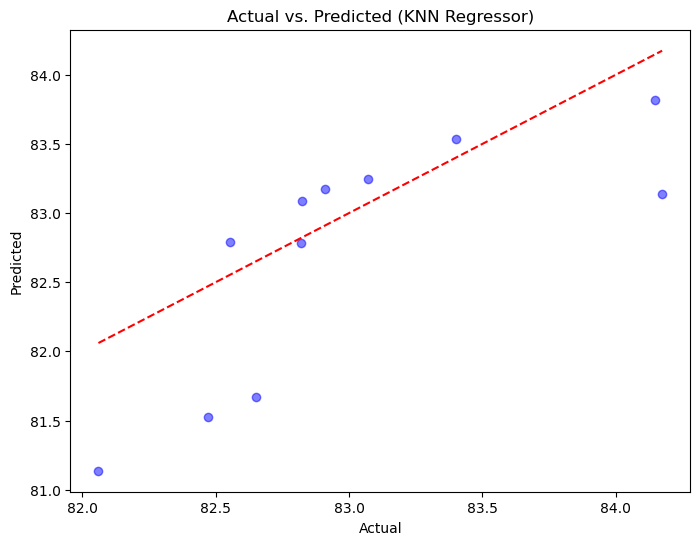

In [38]:
from sklearn.neighbors import KNeighborsRegressor  
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and Train the KNN Regression Model
knn_regressor = KNeighborsRegressor(n_neighbors=5, weights='distance')  
knn_regressor.fit(X_train, y_train)


y_pred = knn_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate R-squared value
r_squared = r2_score(y_test, y_pred)
print("R-squared Value:", r_squared)

# Create a scatter plot of actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted (KNN Regressor)')  
plt.show()

In [40]:
# Separate the temperature column before prediction
X_temp = new_df_filtered['Hurs'].values.reshape(-1, 1)
X_new = new_df_filtered.drop(['Hurs'], axis=1).values

# Assuming rf_model is your trained Random Forest model
future_predictions = knn_regressor.predict(X_new)

print(future_predictions)
print(future_predictions.shape)

[83.31510523 83.19878909 83.13980058 83.10274238 83.0768033  83.05742717
 83.04230906 83.03013729 83.02010172 83.01167092]
(10,)


In [41]:
# Assuming X_temp and future_predictions are NumPy arrays
comparison_df = pd.DataFrame({
    'Actual Hurs': X_temp.flatten(),  # Flatten to make sure it's a 1D array
    'Predicted Hurs': future_predictions
})

# Display the DataFrame
print(comparison_df)

   Actual Hurs  Predicted Hurs
0    81.377878       83.315105
1    83.344048       83.198789
2    81.977419       83.139801
3    83.378172       83.102742
4    83.392087       83.076803
5    81.901780       83.057427
6    82.737965       83.042309
7    81.827022       83.030137
8    82.725019       83.020102
9    80.935507       83.011671


In [42]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

r2 = r2_score(comparison_df['Actual Hurs'], comparison_df['Predicted Hurs'])
print(f"R-squared: {r2}")


mae = mean_absolute_error(comparison_df['Actual Hurs'], comparison_df['Predicted Hurs'])
print(f"Mean Absolute Error: {mae}")


mse = mean_squared_error(comparison_df['Actual Hurs'], comparison_df['Predicted Hurs'])
print(f"Mean Squared Error: {mse}")

R-squared: -0.8012416056612137
Mean Absolute Error: 0.8869932261967677
Mean Squared Error: 1.2573503352824549


Text(0, 0.5, 'Residuals')

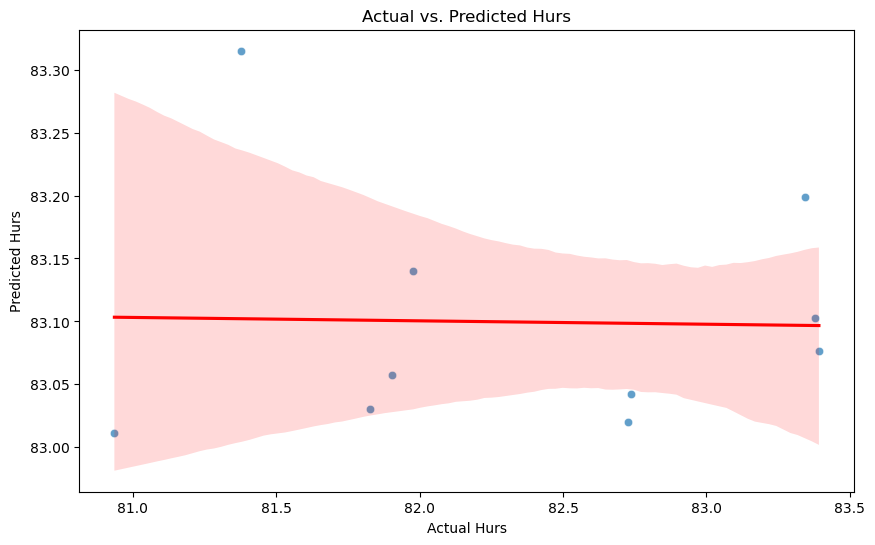

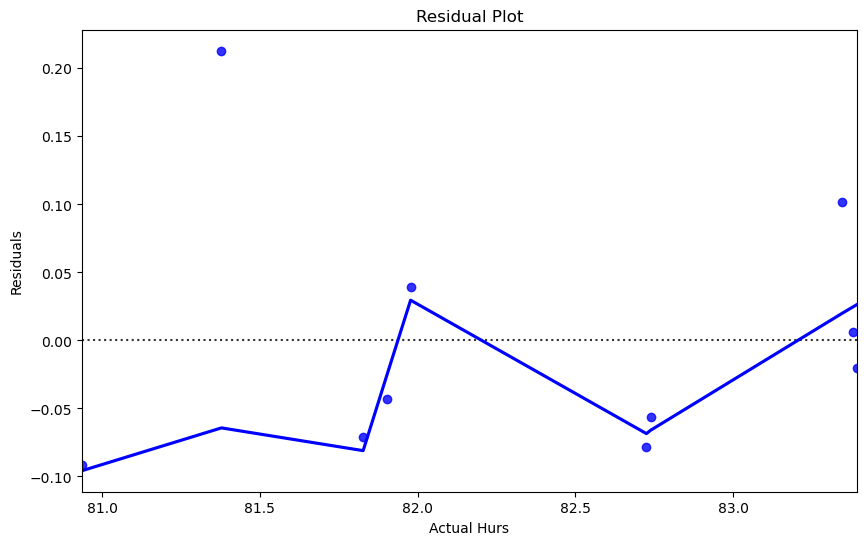

In [43]:
import seaborn as sns
# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Actual Hurs', y='Predicted Hurs', data=comparison_df, alpha=0.7)
plt.title('Actual vs. Predicted Hurs')
plt.xlabel('Actual Hurs')
plt.ylabel('Predicted Hurs')

# Regression line
sns.regplot(x='Actual Hurs', y='Predicted Hurs', data=comparison_df, scatter=False, color='red')

# Residual plot
plt.figure(figsize=(10, 6))
sns.residplot(x='Actual Hurs', y='Predicted Hurs', data=comparison_df, lowess=True, color='blue')
plt.title('Residual Plot')
plt.xlabel('Actual Hurs')
plt.ylabel('Residuals')